# Preprocessing

In [1]:
import pandas
import konlpy # Korean NLP library
import gensim # 
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from konlpy.tag import Mecab # 
from collections import Counter # 
from gensim.models.keyedvectors import Word2VecKeyedVectors # 
from tensorflow.keras.callbacks import EarlyStopping # 
from tensorflow.keras.initializers import Constant # 

In [2]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# Tokenization

In [3]:
# tokenizing Korean
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # word to index dict
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
# index to word dict
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
# add padding upto the length of the longest sentence
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, value=word_to_index['<PAD>'])
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, value=word_to_index['<PAD>'])

# Text classification models

### Common parameters

In [7]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

epoch = 50

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2)

### Embedding layer spec

In [8]:
embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

# tf.keras.preprocessing.sequence.pad_sequences를 통해 word vector를 모두 일정 길이로 맞춰주어야 
# embedding 레이어의 input이 될 수 있음에 주의해 주세요. 
raw_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index['<PAD>'], padding='pre', maxlen=maxlen)
output = embedding(raw_inputs)
print(output) # shape=(146182, 41, 100) = (Num of sentences, length of a sentence, word_vector dimension)

tf.Tensor(
[[[-0.01387556 -0.00558873  0.0145742  ... -0.02274987 -0.01888369
   -0.04464037]
  [-0.01387556 -0.00558873  0.0145742  ... -0.02274987 -0.01888369
   -0.04464037]
  [-0.01387556 -0.00558873  0.0145742  ... -0.02274987 -0.01888369
   -0.04464037]
  ...
  [ 0.01576035 -0.03380444 -0.03234608 ... -0.00783336 -0.01774006
   -0.01156574]
  [-0.00286037  0.04439576  0.0343877  ... -0.04172302 -0.01801141
   -0.02184668]
  [ 0.04055263 -0.02594866  0.02415298 ... -0.0375546   0.01934165
    0.04300183]]

 [[-0.01387556 -0.00558873  0.0145742  ... -0.02274987 -0.01888369
   -0.04464037]
  [-0.01387556 -0.00558873  0.0145742  ... -0.02274987 -0.01888369
   -0.04464037]
  [-0.01387556 -0.00558873  0.0145742  ... -0.02274987 -0.01888369
   -0.04464037]
  ...
  [ 0.02010343 -0.03793452  0.00408244 ...  0.04294416  0.02667006
    0.00472768]
  [ 0.01221018 -0.04886832  0.01500894 ... -0.0349434  -0.02511175
    0.01658148]
  [-0.0484641   0.0301564  -0.03164834 ... -0.04217627  0.0277

## RNN

In [9]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# changing optimizer learning rate : optimizer=tf.keras.optimizer.Adam(learning_rate=1e-3)

history = model.fit(X_train,
                    y_train,
                    epochs=epoch,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 5s 9ms/step - loss: 0.4518 - accuracy: 0.7956 - val_loss: 0.3580 - val_accuracy: 0.8451
Epoch 2/50
229/229 [==============================] - 2s 7ms/step - loss: 0.3439 - accuracy: 0.8584 - val_loss: 0.3414 - val_accuracy: 0.8533
Epoch 3/50
229/229 [==============================] - 2s 7ms/step - loss: 0.3158 - accuracy: 0.8714 - val_loss: 0.3337 - val_accuracy: 0.8552
Epoch 4/50
229/229 [==============================] - 2s 7ms/step - loss: 0.2919 - accuracy: 0.8803 - val_loss: 0.3413 - val_accuracy: 0.8557
Epoch 5/50
229/229 [==============================] - 2s 7ms/step - loss: 0.2704 - accuracy: 0.8898 - val_loss: 0.3407 - val_accuracy: 0.8580
Epoch 6/50
229/229 [==============================] - 2s 7ms/step - loss: 0.2524 - accuracy: 0.8976 - val_loss: 0.3526 - val_accuracy: 0.8569
Epoch 7/50
229/229 [==============================] - 2s 7ms/step - loss: 0.2358 - accuracy: 0.9052 - val_loss: 0.3767 - val_accuracy: 0.8550


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


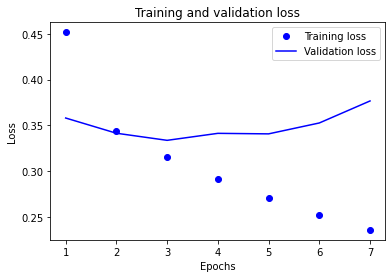

In [11]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

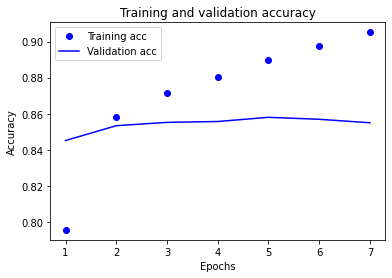

In [12]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

1537/1537 - 3s - loss: 0.3852 - accuracy: 0.8524


In [14]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [15]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.00862932,  0.00382527, -0.02454075, -0.02738672, -0.00023841,
        0.0393791 ,  0.02099113, -0.04400657, -0.01516986, -0.02572815,
        0.02472456, -0.03767864,  0.01690352,  0.00999326,  0.00303446,
        0.03358005, -0.00066241,  0.0251575 , -0.03844195,  0.04278289,
        0.03664502,  0.01198151,  0.01046567,  0.06346107,  0.02749393,
        0.06911409,  0.00826817, -0.02907338,  0.02047427,  0.01396889,
        0.02436075, -0.01356985,  0.00036071,  0.00103915, -0.03208962,
       -0.01379264, -0.009419  , -0.07853662, -0.0665009 ,  0.00862132,
       -0.0181667 ,  0.01575329,  0.02137785, -0.09932426, -0.04213199,
       -0.02438075,  0.03304642,  0.02887282,  0.01710106, -0.02178356,
        0.00942248,  0.11753008,  0.01374671,  0.01516029, -0.03732124,
        0.05095434, -0.02865424,  0.05458427,  0.00212903, -0.0240443 ,
       -0.03437179,  0.02530649, -0.03318037, -0.00138281, -0.01673776,
       -0.0289829 , -0.02455091, -0.0575919 , -0.03129423,  0.00

In [16]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

[('점', 0.5917784571647644), ('...!', 0.5821252465248108), ('..!!', 0.5630610585212708), ('욥', 0.5475978851318359), ('그려진', 0.5467716455459595), ('줌', 0.5421820282936096), ('던데', 0.5412024259567261), ('드', 0.5356253981590271), ('!!!', 0.5346950888633728), ('........', 0.5299351811408997)]
[('로드', 0.34039101004600525), ('이룬', 0.3365635275840759), ('컷', 0.33534595370292664), ('지키', 0.3331010639667511), ('You', 0.3280898928642273), ('기준', 0.31166133284568787), ('완성도', 0.31138721108436584), ('파격', 0.31092017889022827), ('하하', 0.30743399262428284), ('이장우', 0.3052905201911926)]


In [17]:
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word2vec.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [18]:
print(word2vec.wv.most_similar('영화'))
print(word2vec.wv.most_similar('끝'))

[('드라마', 0.8418774008750916), ('뮤지컬', 0.7775140404701233), ('코미디', 0.7489107251167297), ('다큐멘터리', 0.7401294708251953), ('헐리우드', 0.7397844195365906), ('애니메이션', 0.7170552015304565), ('독립영화', 0.7113528251647949), ('로맨틱', 0.7107657194137573), ('장편', 0.7101576924324036), ('극영화', 0.7045413255691528)]
[('마지막', 0.6325399875640869), ('결판', 0.5526015758514404), ('발목', 0.5465342402458191), ('산산조각', 0.5418900847434998), ('막바지', 0.5412753820419312), ('싫증', 0.5256820917129517), ('양쪽', 0.5253474116325378), ('무릎', 0.5246764421463013), ('후', 0.5051813721656799), ('이어진', 0.5038793087005615)]


In [19]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [20]:
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(64))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dropout_5 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
# 학습의 진행
model.compile(optimizer='adam', # changing optimizer learning rate : optimizer=tf.keras.optimizer.Adam(learning_rate=1e-3)
              loss='binary_crossentropy',
              metrics=['accuracy'],)
              
history = model.fit(X_train,
                    y_train,
                    epochs=epoch,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 4s 9ms/step - loss: 0.5753 - accuracy: 0.6889 - val_loss: 0.4458 - val_accuracy: 0.7931
Epoch 2/50
229/229 [==============================] - 2s 7ms/step - loss: 0.4507 - accuracy: 0.7939 - val_loss: 0.3838 - val_accuracy: 0.8264
Epoch 3/50
229/229 [==============================] - 2s 7ms/step - loss: 0.4015 - accuracy: 0.8220 - val_loss: 0.3582 - val_accuracy: 0.8405
Epoch 4/50
229/229 [==============================] - 2s 7ms/step - loss: 0.3720 - accuracy: 0.8371 - val_loss: 0.3417 - val_accuracy: 0.8517
Epoch 5/50
229/229 [==============================] - 2s 7ms/step - loss: 0.3545 - accuracy: 0.8468 - val_loss: 0.3368 - val_accuracy: 0.8539
Epoch 6/50
229/229 [==============================] - 2s 7ms/step - loss: 0.3395 - accuracy: 0.8542 - val_loss: 0.3269 - val_accuracy: 0.8589
Epoch 7/50
229/229 [==============================] - 2s 7ms/step - loss: 0.3300 - accuracy: 0.8582 - val_loss: 0.3268 - val_accuracy: 0.8601
Epoch 

In [22]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3390 - accuracy: 0.8621
[0.33903250098228455, 0.8621152639389038]


## 1-D CNN

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)         

In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# changing optimizer learning rate : optimizer=tf.keras.optimizer.Adam(learning_rate=1e-3)

history = model.fit(X_train,
                    y_train,
                    epochs=epoch,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 3s 7ms/step - loss: 0.5289 - accuracy: 0.7276 - val_loss: 0.3657 - val_accuracy: 0.8422
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3682 - accuracy: 0.8497 - val_loss: 0.3394 - val_accuracy: 0.8528
Epoch 3/50
229/229 [==============================] - 1s 6ms/step - loss: 0.3272 - accuracy: 0.8682 - val_loss: 0.3326 - val_accuracy: 0.8568
Epoch 4/50
229/229 [==============================] - 1s 6ms/step - loss: 0.2960 - accuracy: 0.8811 - val_loss: 0.3359 - val_accuracy: 0.8556
Epoch 5/50
229/229 [==============================] - 1s 6ms/step - loss: 0.2663 - accuracy: 0.8969 - val_loss: 0.3495 - val_accuracy: 0.8528


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


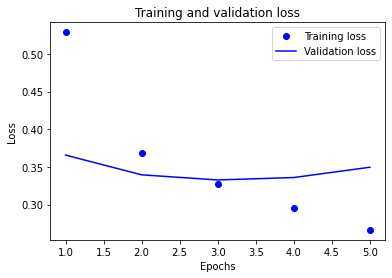

In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

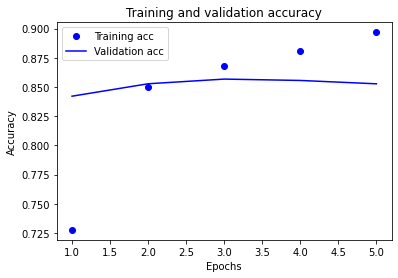

In [26]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

1537/1537 - 3s - loss: 0.3536 - accuracy: 0.8502


In [28]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [29]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.01099372,  0.00360892, -0.00205192,  0.01665706, -0.01386241,
        0.01959182,  0.01178118,  0.02230112,  0.04301004,  0.00203041,
       -0.00651331,  0.00463925,  0.0452404 ,  0.05368001,  0.02464261,
        0.00806881,  0.00445313,  0.02292169, -0.01685156, -0.00567405,
       -0.03833687,  0.02049153, -0.0071995 , -0.00902289, -0.03263934,
       -0.01069261,  0.02170811, -0.00709436, -0.02576612,  0.02122753,
       -0.02008373,  0.00030319,  0.00883347,  0.04265922,  0.05256716,
       -0.00668952,  0.04407386, -0.02304407, -0.00605355,  0.00653796,
       -0.0517576 ,  0.03886561,  0.01854204,  0.03345982, -0.03688717,
        0.01100003,  0.02135065, -0.05302712, -0.00053081,  0.01813706,
        0.05944268,  0.00835326,  0.04232287,  0.02656437,  0.00120489,
        0.00876114, -0.04819718, -0.05345993, -0.03743309,  0.01436577,
        0.0132713 ,  0.01647734,  0.0026471 ,  0.03832681, -0.05481616,
        0.01075026, -0.01905985, -0.00317194, -0.00526653,  0.01

In [30]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

[('쩐', 0.41241028904914856), ('습니다', 0.4002785384654999), ('d', 0.3942773938179016), ('신성', 0.3872101604938507), ('드리', 0.3799425959587097), ('명복', 0.36757543683052063), ('시네마', 0.3662514090538025), ('리라', 0.3649052381515503), ('라이토', 0.36346304416656494), ('애정', 0.3581434190273285)]
[('했어도', 0.40517327189445496), ('정말', 0.40096110105514526), ('보통', 0.4005664885044098), ('필수', 0.39494574069976807), ('본성', 0.386637419462204), ('라라', 0.3776002824306488), ('갱스터', 0.3738860785961151), ('공격', 0.36497634649276733), ('냐구', 0.36432650685310364), ('금물', 0.3548336327075958)]


In [31]:
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word2vec.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [32]:
print(word2vec.wv.most_similar("영화"))
print(word2vec.wv.most_similar("나"))

[('드라마', 0.8418774008750916), ('뮤지컬', 0.7775140404701233), ('코미디', 0.7489107251167297), ('다큐멘터리', 0.7401294708251953), ('헐리우드', 0.7397844195365906), ('애니메이션', 0.7170552015304565), ('독립영화', 0.7113528251647949), ('로맨틱', 0.7107657194137573), ('장편', 0.7101576924324036), ('극영화', 0.7045413255691528)]
[('든', 0.546347975730896), ('와', 0.5454912781715393), ('똥', 0.5381466150283813), ('항상', 0.5252891778945923), ('가', 0.5160491466522217), ('누에', 0.5154241919517517), ('목욕', 0.5139148235321045), ('성게', 0.5074856281280518), ('내', 0.5045832991600037), ('미역', 0.5039044618606567)]


In [33]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [34]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 41, 100)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
dropout_13 (Dropout)         (None, 35, 16)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)            

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# changing optimizer learning rate : optimizer=tf.keras.optimizer.Adam(learning_rate=1e-3)

history = model.fit(X_train,
                    y_train,
                    epochs=epoch,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 2s 7ms/step - loss: 0.7102 - accuracy: 0.5113 - val_loss: 0.6879 - val_accuracy: 0.5724
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.6523 - accuracy: 0.6053 - val_loss: 0.5742 - val_accuracy: 0.7283
Epoch 3/50
229/229 [==============================] - 1s 6ms/step - loss: 0.5736 - accuracy: 0.7079 - val_loss: 0.5054 - val_accuracy: 0.7796
Epoch 4/50
229/229 [==============================] - 1s 6ms/step - loss: 0.5220 - accuracy: 0.7498 - val_loss: 0.4590 - val_accuracy: 0.8032
Epoch 5/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4869 - accuracy: 0.7763 - val_loss: 0.4324 - val_accuracy: 0.8173
Epoch 6/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4616 - accuracy: 0.7926 - val_loss: 0.4096 - val_accuracy: 0.8263
Epoch 7/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4449 - accuracy: 0.8032 - val_loss: 0.4038 - val_accuracy: 0.8306
Epoch 

In [36]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

1537/1537 - 2s - loss: 0.3396 - accuracy: 0.8518


### GlobalMaxPooling1D

In [37]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 808       
_________________________________________________________________
dropout_20 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [38]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# changing optimizer learning rate : optimizer=tf.keras.optimizer.Adam(learning_rate=1e-3)

history = model.fit(X_train,
                    y_train,
                    epochs=epoch,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 2s 5ms/step - loss: 0.5303 - accuracy: 0.7483 - val_loss: 0.3891 - val_accuracy: 0.8354
Epoch 2/50
229/229 [==============================] - 1s 4ms/step - loss: 0.3753 - accuracy: 0.8408 - val_loss: 0.3547 - val_accuracy: 0.8487
Epoch 3/50
229/229 [==============================] - 1s 4ms/step - loss: 0.3453 - accuracy: 0.8583 - val_loss: 0.3460 - val_accuracy: 0.8513
Epoch 4/50
229/229 [==============================] - 1s 4ms/step - loss: 0.3256 - accuracy: 0.8679 - val_loss: 0.3444 - val_accuracy: 0.8520
Epoch 5/50
229/229 [==============================] - 1s 4ms/step - loss: 0.3134 - accuracy: 0.8741 - val_loss: 0.3441 - val_accuracy: 0.8509
Epoch 6/50
229/229 [==============================] - 1s 4ms/step - loss: 0.3045 - accuracy: 0.8788 - val_loss: 0.3446 - val_accuracy: 0.8516


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


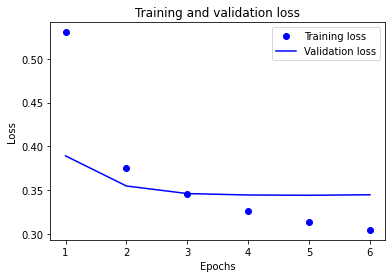

In [39]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

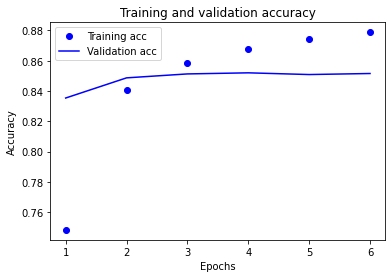

In [40]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [41]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

1537/1537 - 2s - loss: 0.3523 - accuracy: 0.8465


In [42]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [43]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.00909607, -0.00412592, -0.01204597, -0.00322462, -0.04804758,
        0.00778334, -0.04098774, -0.02723762, -0.00260816, -0.00406305,
       -0.00255359, -0.0052585 , -0.00327519, -0.04622067, -0.04508838,
       -0.00251254, -0.02979277, -0.02346618, -0.01283307, -0.04261519,
       -0.00390274, -0.00425251, -0.00993877, -0.00760305, -0.00324748,
        0.00536722, -0.04519489, -0.03820354, -0.00312719, -0.0017163 ,
       -0.04684147, -0.04621753, -0.00444323,  0.02901006, -0.00340378,
       -0.03174254, -0.0053081 ,  0.05522755, -0.00470962, -0.04884449,
        0.05075246, -0.00920505, -0.00098384, -0.00574633, -0.01672866,
       -0.00518666, -0.02201864, -0.00410079, -0.01106229, -0.01047765,
       -0.00539248, -0.00979506, -0.02699096, -0.01867846, -0.01846895,
       -0.00858642, -0.04489883, -0.02742648, -0.03135455, -0.01405588,
       -0.01717361, -0.00369471, -0.00280083, -0.00558889, -0.03122239,
       -0.03235247, -0.02222031, -0.00402722, -0.04886702, -0.00

In [44]:
print(word_vectors.similar_by_word("영화"))
print(word_vectors.similar_by_word("나"))

[('까지', 0.5503398180007935), (',', 0.5078725218772888), ('연기력', 0.49874815344810486), ('되', 0.4836415648460388), ('인', 0.469645231962204), ('이런', 0.4612053632736206), ('듬', 0.46021926403045654), ('나', 0.4573058784008026), ('아', 0.4503738582134247), ('존재감', 0.448356568813324)]
[('인', 0.5479284524917603), ('다', 0.4824025630950928), ('것', 0.47672370076179504), ('일', 0.4642624258995056), ('을', 0.4609019458293915), (',', 0.4602898061275482), ('영화', 0.4573058784008026), ('도움', 0.4541778862476349), ('고', 0.44915440678596497), ('같이', 0.4486711919307709)]


In [45]:
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word2vec.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [46]:
print(word2vec.wv.most_similar("영화"))
print(word2vec.wv.most_similar("나"))

[('드라마', 0.8418774008750916), ('뮤지컬', 0.7775140404701233), ('코미디', 0.7489107251167297), ('다큐멘터리', 0.7401294708251953), ('헐리우드', 0.7397844195365906), ('애니메이션', 0.7170552015304565), ('독립영화', 0.7113528251647949), ('로맨틱', 0.7107657194137573), ('장편', 0.7101576924324036), ('극영화', 0.7045413255691528)]
[('든', 0.546347975730896), ('와', 0.5454912781715393), ('똥', 0.5381466150283813), ('항상', 0.5252891778945923), ('가', 0.5160491466522217), ('누에', 0.5154241919517517), ('목욕', 0.5139148235321045), ('성게', 0.5074856281280518), ('내', 0.5045832991600037), ('미역', 0.5039044618606567)]


In [47]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [48]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
dropout_21 (Dropout)         (None, 41, 100)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
dropout_22 (Dropout)         (None, 35, 16)            0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)            

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# changing optimizer learning rate : optimizer=tf.keras.optimizer.Adam(learning_rate=1e-3)

history = model.fit(X_train,
                    y_train,
                    epochs=epoch,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    verbose=1)

Epoch 1/50
229/229 [==============================] - 2s 7ms/step - loss: 0.6883 - accuracy: 0.5515 - val_loss: 0.6209 - val_accuracy: 0.6977
Epoch 2/50
229/229 [==============================] - 1s 6ms/step - loss: 0.6027 - accuracy: 0.6812 - val_loss: 0.5240 - val_accuracy: 0.7624
Epoch 3/50
229/229 [==============================] - 1s 6ms/step - loss: 0.5398 - accuracy: 0.7402 - val_loss: 0.4735 - val_accuracy: 0.7916
Epoch 4/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4990 - accuracy: 0.7694 - val_loss: 0.4390 - val_accuracy: 0.8110
Epoch 5/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4656 - accuracy: 0.7904 - val_loss: 0.4143 - val_accuracy: 0.8230
Epoch 6/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4434 - accuracy: 0.8042 - val_loss: 0.3946 - val_accuracy: 0.8306
Epoch 7/50
229/229 [==============================] - 1s 6ms/step - loss: 0.4281 - accuracy: 0.8127 - val_loss: 0.3824 - val_accuracy: 0.8341
Epoch 

In [50]:
result = model.evaluate(X_test, y_test, verbose=2) #0.8528

1537/1537 - 2s - loss: 0.3396 - accuracy: 0.8533


# 회고

1회차
- 이번 프로젝트를 진행하며 3가지 방식으로 모델을 구축하였다.
    - RNN, 1-D CNN, 그리고 Globalmaxpooling 1D
- 처음에는 데이터 전처리 흐름이 잘 이해하기 힘들어서 여러번 노드를 보며 진행하였다.
    - IMDB의 데이터셋은 인코딩부터 word_to_index까지 다 이미 모듈이 있어서 다운을 받음으로 해결이 되었지만, Naver Sentiment Movie Corpus (NSMC)는 전혀 가공되지 않은 파일이어서 전처리 과정이 힘들었다.
- 시각화를 해본 결과, loss가 0.6 이하로 내려가지 않았고 accuracy도 50% 이상으로 올라가지 않았다

2회차
- 1회차 때 모델 학습결과가 크게 바뀌지 않는것에 의문이 들었고, 자세히 살펴본 결과 단어사전의 크기를 10으로 두었다는 것을 알게됐다.
- 또한 벡터 차원의 수도 4로 둔것을 찾아냈다.
- 단어사전 크기를 10000으로 그리고 벡터 차원의 수는 16으로 바꿔주니 loss값과 accuracy값이 올라가는 것을 확인할 수 있었다.
- 다만 val_accuracy가 기대치에 못 미치는 경향을 보였다.
- 그 이유가 그래프에서 볼 수 있듯이 학습을 하면 할수록 overfitting 되는 상황이 발생하기 때문이었다.
- epoch을 20으로 할 때나 50으로 할 때 비슷한 경향을 보였다.

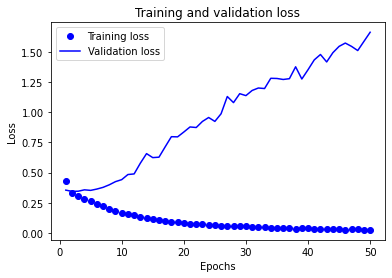

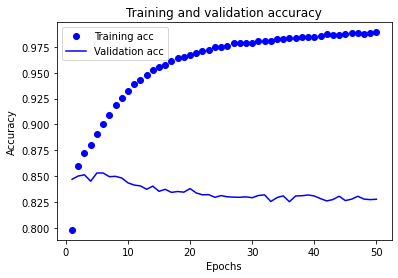

- 과적합을 방지하기 위해 early stopping을 추가해 주었고, model blueprint에 dropout도 추가해 주었고, 기대치에 맞는 정확도를 보였다.
- 정확도는 맞췄지만, 단어 '영화'와 '나'의 유사단어들을 보니 비슷한 느낌을 주는 단어들이 나오지 않았다.

3회차
- 단어의 유사도를 맞추기 위해 `word2vec_ko.model`를 사용했다.
    - `FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/sentiment_classification/data/word2vec_ko.model.wv.vectors.npy'` 에러가 났다
    - 파일이 없다는 에러라는 걸 알았지만, `word2vec_ko.model`모델을 돌리면 `.wv` `wv.vectors.npy`등등 나오는 것으로 처음엔 생각해서 많이 헤맸다.
- `word2vec_ko.model`을 불러오는 문제가 무사히 해결되고 나서 generator cannot be iterated라는 문제가 word2vec에서 embedding matrix에 덮어씌우고 새로 학습하려는 과정에서 생겼다.
    - 결국에는 word2vec 뒤에 `.wv`를 안 붙여서 생기는 문제라는 것을 알아서 고쳤다.
- Google vocab dataset처럼 단어장을 불러오고 덮어씌우고 과정에서 5% 정확도의 상승률을 기대했지만, 1%이하로 상승했었다.
